In [1]:
!pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gauravkhurana9713","key":"06a3328b63c6476778fdf76457725eb6"}'}

In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 341M/346M [00:03<00:00, 141MB/s]
100% 346M/346M [00:03<00:00, 106MB/s]


In [6]:
!ls

 image_classification_dataset				   'kaggle (1).json'
 inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5   kaggle.json
 intel-image-classification.zip				    sample_data


In [ ]:
!unzip \*.zip && rm *.zip

In [8]:
!mkdir image_classification_dataset

mkdir: cannot create directory ‘image_classification_dataset’: File exists


In [9]:
!cp -r seg_test ./image_classification_dataset/
!cp -r seg_pred ./image_classification_dataset/
!cp -r seg_train ./image_classification_dataset/

In [10]:
!rm -r seg_test
!rm -r seg_pred
!rm -r seg_train

In [11]:
!ls

 image_classification_dataset				    kaggle.json
 inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5   sample_data
'kaggle (1).json'


In [12]:
!ls image_classification_dataset/seg_test/seg_test/

buildings  forest  glacier  mountain  sea  street


In [13]:
import os

In [14]:
image_class_names = []

In [15]:
for x in os.listdir('image_classification_dataset/seg_train/seg_train'):
  image_class_names.append(x)  

In [16]:
image_class_names

['glacier', 'mountain', 'buildings', 'street', 'sea', 'forest']

In [17]:
import numpy as np
from glob import glob

In [18]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [37]:
#all_images_glacier_path = glob('image_classification_dataset/seg_train/seg_train/glacier/*.jpg')

In [38]:
len(all_images_glacier_path)

2404

In [19]:
def get_datasets(path):
  x_train = []
  y_train = []
  i = 0
  for label in image_class_names:
    all_img_class_path = glob(path+'/'+label+'/*.jpg')
    for img_path in all_img_class_path:
      img = load_img(img_path,target_size=(150,150))
      img = img_to_array(img)
      img = img/255.0
      x_train.append(img)
      y_train.append(i)
    i += 1
  return np.array(x_train), np.array(y_train)

In [20]:
!ls image_classification_dataset/seg_train/seg_train


buildings  forest  glacier  mountain  sea  street


In [21]:
train_path = 'image_classification_dataset/seg_train/seg_train'
X_train, Y_train = get_datasets(train_path)

In [23]:
print(X_train.shape,Y_train.shape)

(14034, 150, 150, 3) (14034,)


In [24]:
#!ls image_classification_dataset/seg_test/seg_test/
validation_path = 'image_classification_dataset/seg_test/seg_test'
X_val, Y_val = get_datasets(validation_path)

In [25]:
print(X_val.shape,Y_val.shape)

(3000, 150, 150, 3) (3000,)


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [46]:
!kaggle datasets download -d madmaxliu/inceptionv3

 91% 70.0M/77.3M [00:02<00:00, 24.4MB/s]
100% 77.3M/77.3M [00:02<00:00, 27.3MB/s]


In [48]:
!unzip \*.zip && rm *.zip 

Archive:  inceptionv3.zip
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [49]:
!ls

image_classification_dataset				  kaggle.json
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5  sample_data


In [28]:
local_weight_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [29]:
pre_trained_model = InceptionV3(input_shape=(X_train[0].shape),
                                include_top = False,
                                weights=None)

In [30]:
pre_trained_model.load_weights(local_weight_file)

In [31]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [32]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [33]:
last_layer = pre_trained_model.get_layer('mixed7')

In [34]:
last_output = last_layer.output

In [35]:
x = Flatten()(last_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation='softmax')(x)

In [36]:
model = Model(pre_trained_model.input,x)

In [37]:
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [38]:
r = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=5,verbose=1)

Epoch 1/5
439/439 [==============================] - 47s 107ms/step - loss: 1.0268 - acc: 0.8375 - val_loss: 0.5484 - val_acc: 0.8243
Epoch 2/5
439/439 [==============================] - 45s 103ms/step - loss: 0.3664 - acc: 0.9030 - val_loss: 0.4038 - val_acc: 0.8847
Epoch 3/5
439/439 [==============================] - 45s 103ms/step - loss: 0.2662 - acc: 0.9267 - val_loss: 0.4414 - val_acc: 0.9027
Epoch 4/5
439/439 [==============================] - 45s 103ms/step - loss: 0.2168 - acc: 0.9454 - val_loss: 0.5424 - val_acc: 0.9103
Epoch 5/5
439/439 [==============================] - 45s 103ms/step - loss: 0.1615 - acc: 0.9578 - val_loss: 0.7569 - val_acc: 0.8757


In [39]:
import matplotlib.pyplot as plt

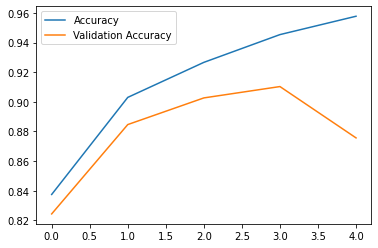

In [40]:
plt.plot(r.history['acc'],label='Accuracy')
plt.plot(r.history['val_acc'],label='Validation Accuracy')
plt.legend()

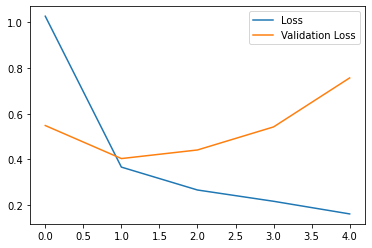

In [41]:
plt.plot(r.history['loss'],label='Loss')
plt.plot(r.history['val_loss'],label='Validation Loss')
plt.legend()